In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.layers import Dense, LeakyReLU, Dropout, Input, BatchNormalization
from keras.layers import Reshape, Conv2D, Conv2DTranspose, Flatten, Activation
from keras.models import Model,Sequential

In [2]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Normalization
X_train = X_train.astype(np.float32) / 127.5 - 1
# Reshape
X_train = X_train.reshape(-1, 28, 28, 1)

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
from keras.optimizers import Adam
adam = Adam(lr = 0.0002, beta_1 = 0.5)

In [4]:
noise_dim = 10

generator = Sequential(name='generator')

generator.add(Dense(256*7*7, input_shape=(noise_dim,)))
generator.add(LeakyReLU())

generator.add(Reshape((7,7,256)))

generator.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU())
generator.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU())

generator.add(Conv2D(1, kernel_size=3, padding='same'))
generator.add(Activation('tanh'))

generator.summary()


Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             137984    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       295040    
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 64)        73

In [5]:
from tensorflow.keras.initializers import RandomNormal

discriminator = Sequential(name = 'discriminator')

discriminator.add(Conv2D(32, kernel_size=3, strides=2, padding='same', input_shape=(28,28,1)))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
discriminator.add(LeakyReLU())
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.5))
discriminator.add(Flatten() )
discriminator.add(Dense(1, activation = 'sigmoid'))

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 4, 4, 128)       

In [6]:
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

In [7]:
discriminator.trainable = False

gan_input = Input(shape=(noise_dim,))
x = generator(gan_input)
output = discriminator(x)

In [8]:
gan = Model(gan_input, output, name='gan')
gan.summary()

Model: "gan"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
generator (Sequential)       (None, 28, 28, 1)         508161    
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 94721     
Total params: 602,882
Trainable params: 507,777
Non-trainable params: 95,105
_________________________________________________________________


In [9]:
gan.compile(loss='binary_crossentropy', optimizer=adam)

In [14]:
def get_batches(data, batch_size):
  batches=[]

  for i in range(data.shape[0]// batch_size):
    batch = data[i*batch_size:(1+i)*batch_size]
    batches.append(batch)
  return np.asarray(batches)

In [11]:
def visualize_training(epoch, d_losses, g_losses):
  print('epoch:', epoch)
  noise = np.random.normal(0,1,size=(24, noise_dim))
  generated_images = generator.predict(noise)
  generated_images = generated_images.reshape(-1, 28,28)

  plt.figure(figsize=(8,4))
  for i in range(generated_images.shape[0]):
    plt.subplot(4,6,i+1)
    plt.imshow(generated_images[i], interpolation='nearest', cmap='Greys_r')
    plt.axis('off')
  plt.tight_layout()
  plt.show()

epoch: 1


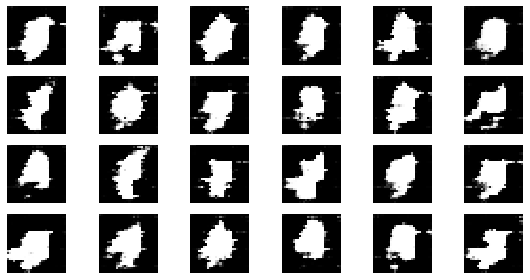

epoch: 5


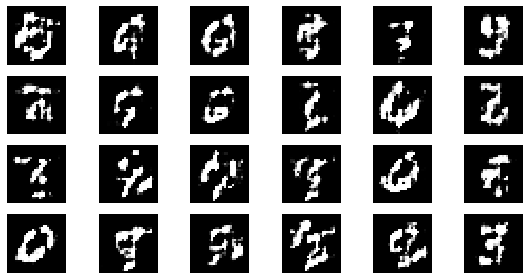

epoch: 10


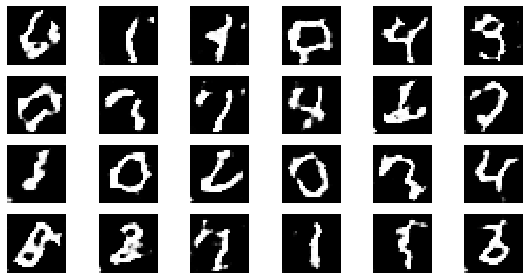

epoch: 15


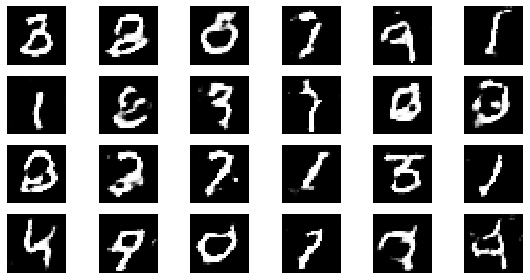

epoch: 20


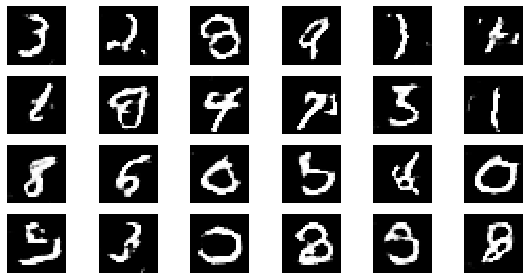

epoch: 25


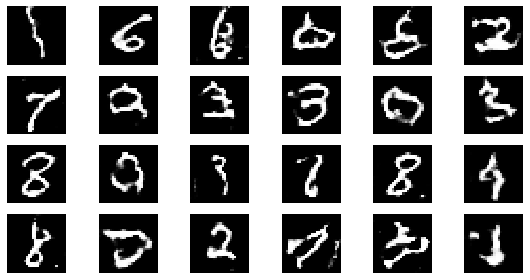

epoch: 30


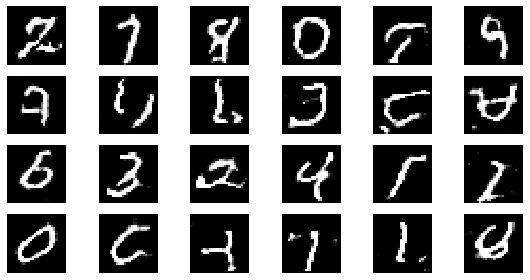

epoch: 35


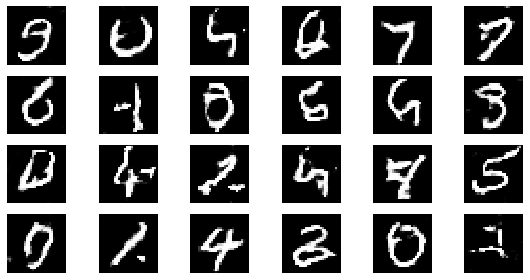

epoch: 40


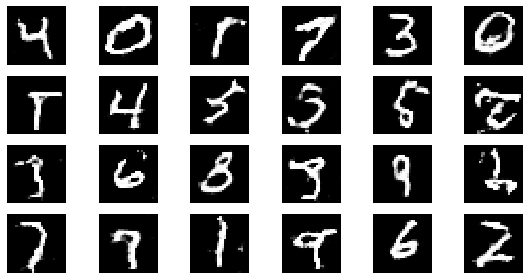

epoch: 45


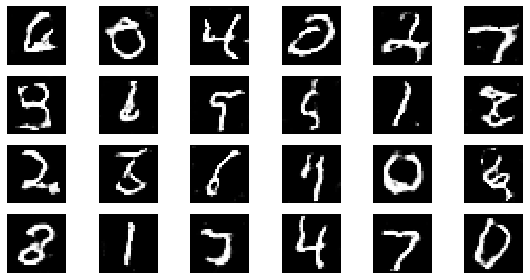

epoch: 50


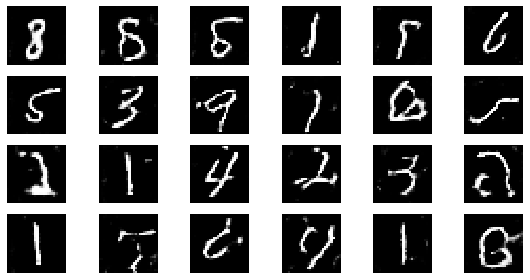

CPU times: user 20min 55s, sys: 1min 21s, total: 22min 16s
Wall time: 26min 28s


In [15]:
%%time
EPOCHS = 50
BATCH_SIZE=128

d_losses=[]
g_losses=[]

for epoch in range(1, EPOCHS+1):
  for real_images in get_batches(X_train, BATCH_SIZE):
    input_noise = np.random.uniform(-1,1,size=[BATCH_SIZE, noise_dim])

    generated_images = generator.predict(input_noise)
    x_dis = np.concatenate([real_images, generated_images])
    y_dis = np.zeros(2*BATCH_SIZE)
    y_dis[:BATCH_SIZE] = 1

    discriminator.trainable=True
    d_loss = discriminator.train_on_batch(x_dis, y_dis)

    noise = np.random.uniform(-1,1,size=[BATCH_SIZE, noise_dim])
    y_gan = np.ones(BATCH_SIZE)

    discriminator.trainable=False
    g_loss = gan.train_on_batch(noise, y_gan)

  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if epoch == 1 or epoch % 5 ==0:
    visualize_training(epoch, d_losses, g_losses)